In [16]:
#import all needed libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm

In [3]:
# Define the new working directory path
new_working_directory = r'C:\Users\Victor\Documents\GitHub\sports-data'

# Change the current working directory
os.chdir(new_working_directory)

In [4]:
# Define the path 
data_folder = 'data/'

# Load the CSV files to df
df = pd.read_csv(data_folder + 'cleaned_df.csv')

In [5]:
# Take a look to the actual DataFrame
df.head()

,player_id,name,country,height,foot,position,highest_market_value,current_club_domestic_competition_id,number_games_played,total_minutes,...,red_cards_sum,red_cards_avg,goals,avg_goals_per_game,assists,age,year,avg_games_per_year,avg_goals_per_year,avg_assists_per_year
0,122011,Markus Henriksen,Norway,187.0,right,Defender,5000000.0,GB1,165,12199,...,1,0.006061,33,0.200000,22,45.0,6,27.500000,5.500000,3.666667
1,14940,Razvan Rat,Romania,179.0,left,Defender,6500000.0,ES1,97,7690,...,1,0.010309,3,0.030928,13,43.0,5,19.400000,0.600000,2.600000
2,14942,Darijo Srna,Croatia,182.0,right,Defender,17500000.0,IT1,227,19598,...,2,0.008811,22,0.096916,68,45.0,8,28.375000,2.750000,8.500000
3,26267,Fernandinho,Brazil,179.0,right,Midfield,32000000.0,GB1,399,30325,...,3,0.007519,29,0.072682,41,42.0,11,36.272727,2.636364,3.727273
4,55735,Henrikh Mkhitaryan,Armenia,177.0,both,Midfield,37000000.0,IT1,485,35878,...,0,0.000000,128,0.263918,119,43.0,13,37.307692,9.846154,9.153846


## Function definition for plots

Add some explication...

In [17]:
# Function to plot correlation matrix
def plot_correlation_matrix(data, title, position=None):
    if position:
        data = data[data['position'] == position]
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()
    
# Function to plot histograms and scatter plots with regression lines for a list of variables
# Each variable will have two plots: histogram and scatter with regression
def plot_variable_distributions_with_regression(data, variables, target='highest_market_value', poly_order=1):
    num_variables = len(variables)
    num_plots = num_variables * 2  
    num_rows = num_plots // 2 if num_plots % 2 == 0 else (num_plots // 2) + 1 

    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, num_rows * 6))
    axes = axes.ravel()  

    for i, var in enumerate(variables):
        # Plot histogram - left column
        sns.histplot(data[var], kde=True, ax=axes[i*2], color='skyblue')
        axes[i*2].set_title(f'Histogram of {var}')

        # Plot scatter plot with regression line - right column
        if (i*2 + 1) < len(axes):
            sns.regplot(x=var, y=target, data=data, ax=axes[i*2 + 1], color='salmon', order=poly_order, line_kws={'color':'red'})
            axes[i*2 + 1].set_title(f'{var} vs {target} with Regression Line')

    # Remove unused subplots
    for j in range(num_variables * 2, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Function definition for training and evaluating different Models

Add some explication...

Models that we include in our study:

- **LinearRegression**
- **RidgeRegression**
- **LassoRegression**
- **PolynomialRegression**
- **RandomForestRegressor**
- **GradientBoostingRegressor**
- **SVR**

In [21]:
def train_and_evaluate_models(df, position, features):
    # Filter by position
    position_df = df[df['position'] == position]

    X_position = position_df[features]
    y_position = position_df['highest_market_value']

    y_imputer = SimpleImputer(strategy='mean')
    y_position_imputed = y_imputer.fit_transform(y_position.values.reshape(-1, 1)).ravel()

    # Define training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_position, y_position_imputed, test_size=0.2, random_state=42)

    # Apply imputation to the feature data
    X_imputer = SimpleImputer(strategy='mean')
    X_train_imputed = X_imputer.fit_transform(X_train)
    X_test_imputed = X_imputer.transform(X_test)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Initialize models
    models = {
        'LinearRegression': LinearRegression(),
        'RidgeRegression': Ridge(max_iter=10000),
        'LassoRegression': Lasso(max_iter=10000), 
        'PolynomialRegression': make_pipeline(PolynomialFeatures(degree=2), Ridge(max_iter=10000)),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'SVR': SVR()
    }

    results = {}

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_imputed, y_train)

        # Evaluate the model
        if model_name in ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'PolynomialRegression']:
            score = model.score(X_test_scaled, y_test)
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        else:
            score = model.score(X_test_imputed, y_test)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, cv=5)
            
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # Intercept and p-value 
        intercept = None
        p_value = None
        f_value = None

        if hasattr(model, 'coef_'):
            intercept = model.intercept_
            X_train_scaled_with_const = sm.add_constant(X_train_scaled)
            model_sm = sm.OLS(y_train, X_train_scaled_with_const).fit()
            p_value = model_sm.pvalues[-1]  
            f_value = model_sm.fvalue

        results[model_name] = {
            'R^2 score': score,
            'Cross-Validation R^2 mean': cv_mean,
            'Cross-Validation R^2 std': cv_std,
            'Intercept': intercept,
            'P-value': p_value,
            'F-value': f_value
        }
        
    # Save trained models and imputers for future predictions
    trained_models = {}
    for model_name, model in models.items():
        trained_models[model_name] = {
            'model': model,
            'X_imputer': X_imputer,
            'y_imputer': y_imputer
        }

    # Add trained models to the results
    results['trained_models'] = trained_models

    return results



## Function definition for Predicting Market Value for a New Player

Add some explication...

Features to include:

- **Number of games played**
- **Total minutes**
- **Average games per year**
- **Average goals per year**
- **Average goals per game**
- **Goals**
- **Average assists per year**
- **Assists**
- **Age**
- **Red cards**
- **Yellow cards**




In [22]:
def predict_market_value_for_new_player(trained_models, features, new_player_data):
    predictions = {}
    for model_name, components in trained_models.items():
        model = components['model']
        X_imputer = components['X_imputer']
        y_imputer = components['y_imputer']

        # Create new df with the data of the new player
        new_player_df = pd.DataFrame([new_player_data], columns=features)
        
        # Impute values fot the features
        new_player_imputed = X_imputer.transform(new_player_df)

        # Start the prediciton
        predicted_value = model.predict(new_player_imputed)
        predictions[model_name] = predicted_value[0]
        
    return predictions

# Analysis and evaluation of models by different position

Add some explication...

## Goalkeeper

Repeat the analysis for Goalkeeper, remeber getting out of the model irrelevant features, such as goals and assists

In [23]:
# to continue...

## Defender

Before we start, let's plot our correlation matrix to see which characteristics may have a greater impact on predicting market value.

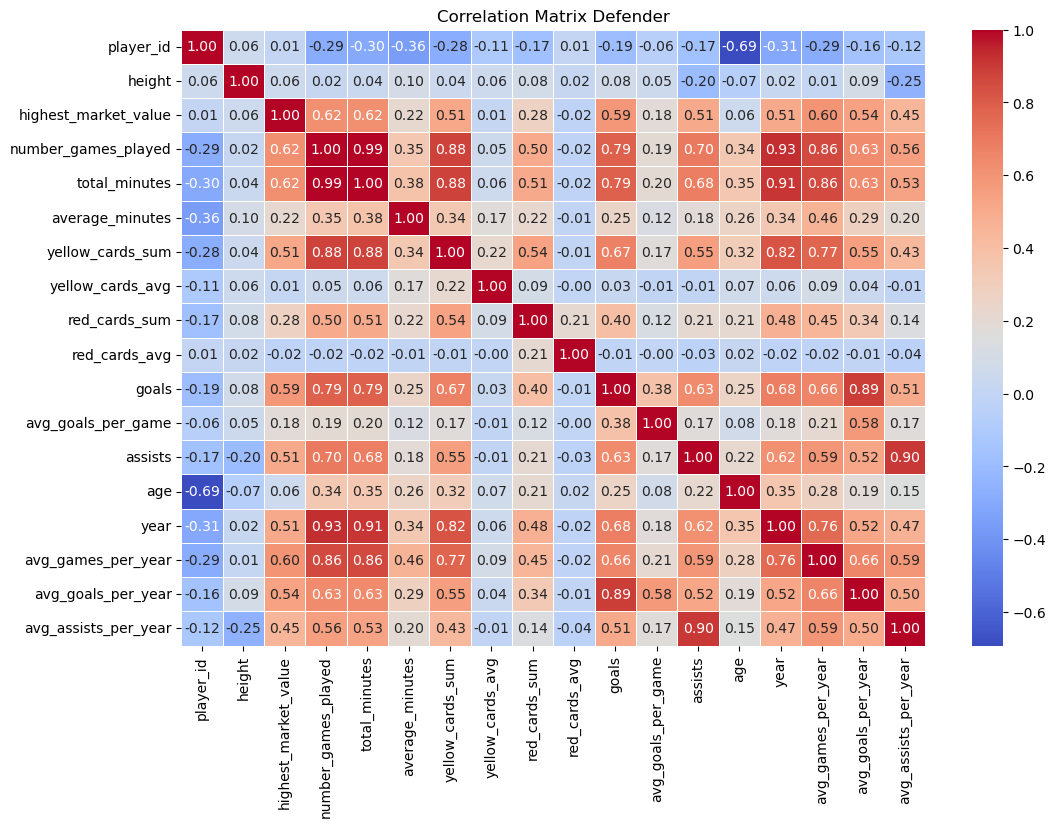

In [24]:
# Plot correlations for Defender
plot_correlation_matrix(df, 'Correlation Matrix Defender', 'Defender')

Looking at the correlation matrix for the defender position, we identified several characteristics with significant correlations to the market value:

- **Number of games played**: Strong positive correlation, indicating that players who have played more games tend to have a higher market value.

- **Total minutes**: Similar to number of games played, actually the same, but still relevant because a player can play 38 games in a season but come off the bench and only play 10 minutes per game. ç

It also shows a strong positive correlation with market value, suggesting that players with more playing time tend to have higher values.

- **Average games per year**: Strong positive correlation, suggesting that players who play more games per year on average are valued higher.

- **Goals**: Strong positive correlation, suggesting that players who score more goals are likely to have higher market values.

- **Assists**: Also shows a good positive correlation, suggesting that players with more assists tend to have higher market values.

- **Average games per game**: This characteristic also shows a strong positive correlation, indicating that a higher average number of goals per game implies a higher market value.

- **Age**: Shows a strong negative correlation, indicating that younger players tend to have higher market values. This is a common trend in football, as younger players are perceived to have more potential and a longer career ahead of them.

- **Red Cards**: Typically, a high number of red cards would negatively correlate with a player's market value. Red cards often lead to suspensions and indicate disciplinary problems, which can reduce a player's value. However, the correlation in the matrix doesn't seem to be extremely strong. It may still be a factor, but its effect seems to be less significant compared to other features.

- **Yellow Cards**: Similarly to red cards, a higher number of yellow cards may indicate a disciplinary problem and potentially lead to suspensions once a certain threshold is reached. Although the correlation is weak, it suggests that it's a factor worth considering. However, like red cards, its impact seems to be less significant compared to other characteristics.

Given the similarities between goals and avg_goals_per_year, and assists and avg_assists_per_year, we will only consider one of each pair (the one with the higher correlation) for further analysis.


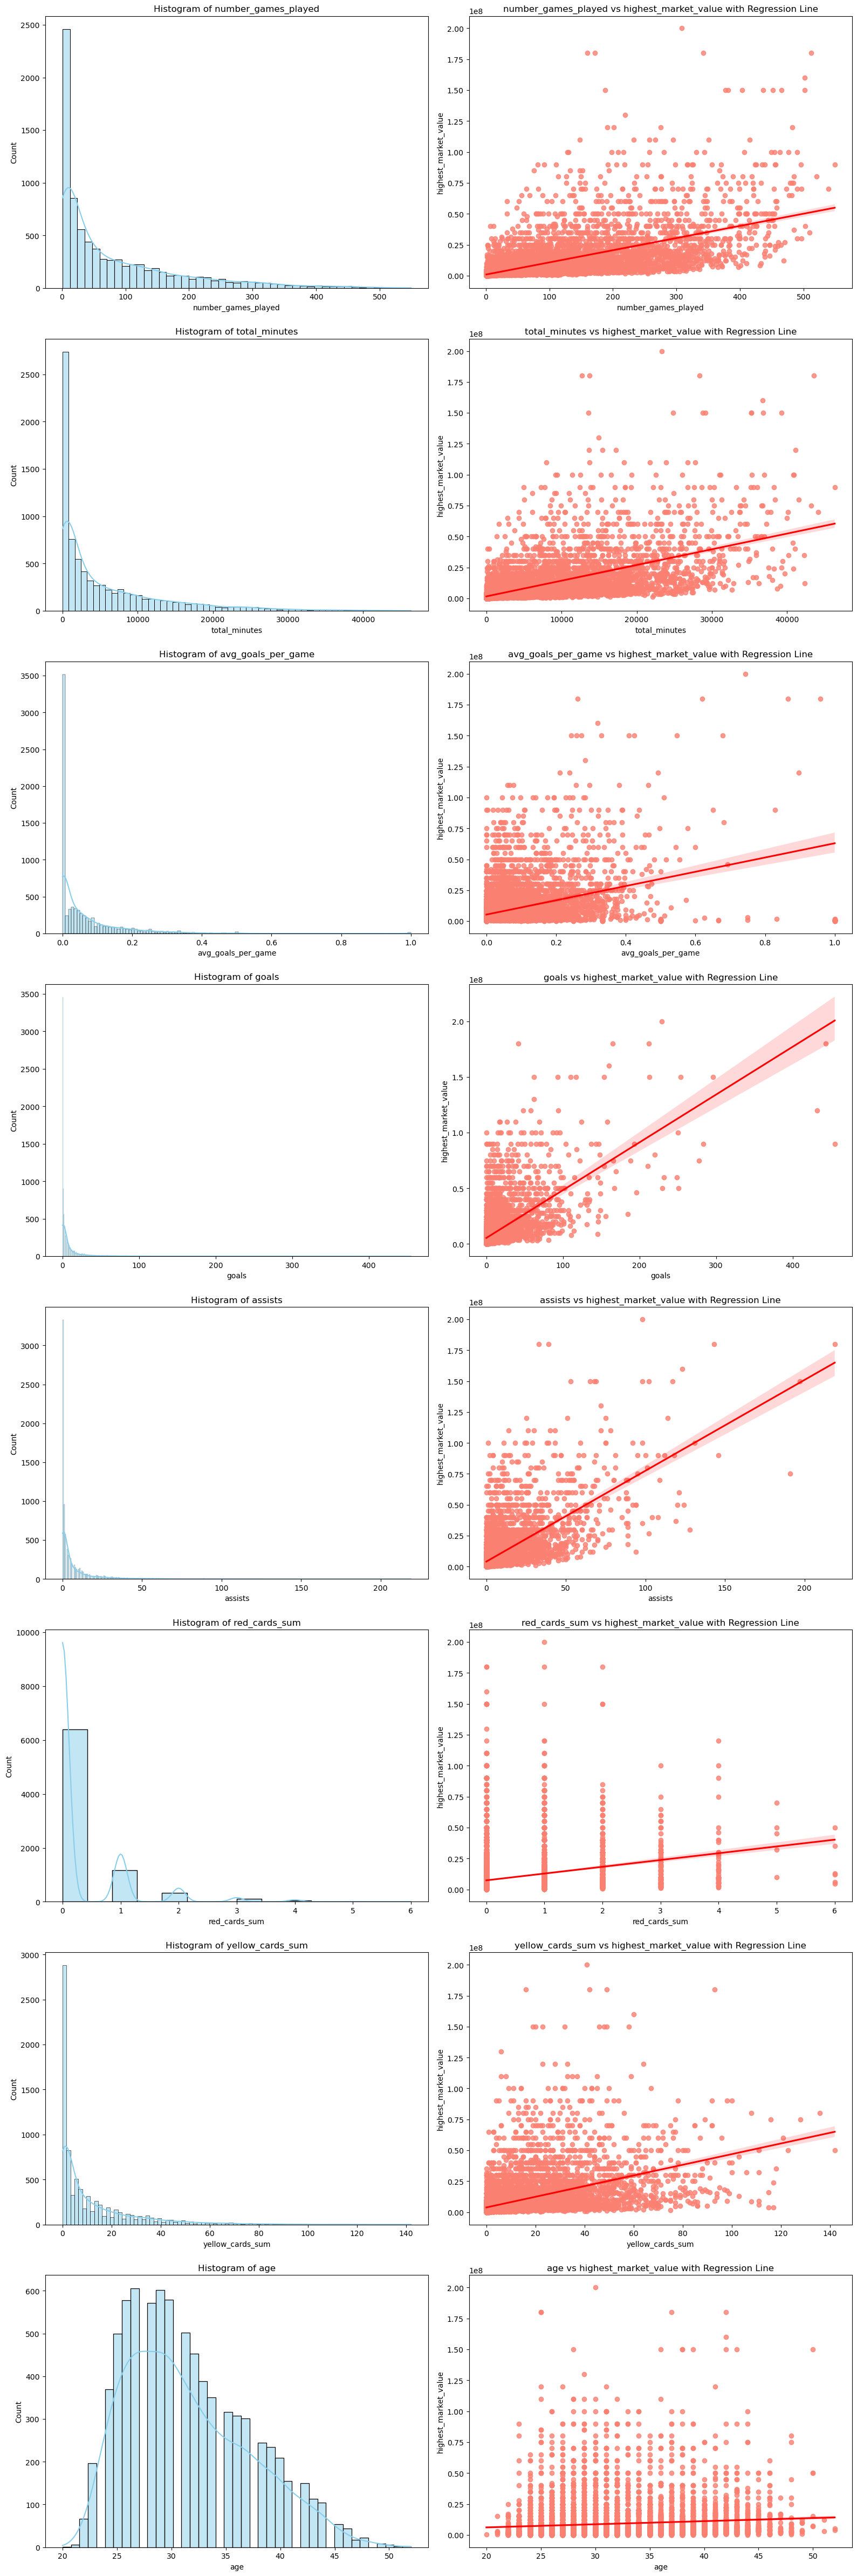

In [25]:
# List of performance features for Defender
features_defender = [
    'number_games_played',
    'total_minutes',
    'avg_goals_per_game',
    'goals',
    'assists',
    'red_cards_sum',
    'yellow_cards_sum',
    'age'
]

# Plot insightful plots for Defender
plot_variable_distributions_with_regression(df, features_defender)

## Defender performance analysis

The graph we are going to look at is made up of histograms and scatter plots with regression lines relating different performance characteristics of players per position, in this case defenders, to the market value of footballers. 

We will first analyse all the histograms, then the scatter plots and draw some conclusions about the correlations.

### Histogram analysis:

- **Assists**: Right-skewed distribution, most players have a low number of assists.
- **Red cards**: Very high peak at zero with a rapid decline, indicating that most players receive very few red cards.
- **Yellow cards**: Right-skewed, most players accumulate few yellow cards.
- **Number of matches played**: Right-skewed, with most players taking part in a lower number of matches.
- **Total minutes played**: Right skewed, indicating that most players have fewer total minutes played.
- **Average goals per game**: Right skewed, indicating that most players have lower average goals per game.
- **Age**: Appears to be somewhat normally distributed, but with a slight right skew, indicating a larger number of younger players.

### Scatter plots with regression line analysis:

- **Assists vs. highest market value**: Positive trend with a concentration of data points at the lower end, suggesting that a higher number of assists may correlate with a higher market value.
- **Red cards vs. highest market value**: Slightly positive trend, although the relationship appears weak due to a large concentration of data points at the lower end of the red card range.
- **Yellow cards vs. highest market value**: Slightly positive trend, with a wide spread of data points indicating a weaker relationship between yellow cards and market value.
- **Number of matches played vs. highest market value**: Positive trend, indicating a possible moderate correlation between playing more games and higher market value.
- **Total minutes played vs. highest market value**: Negative trend, indicating that more minutes played does not necessarily correlate with higher market value.
- **Average goals per game vs. highest market value**: Positive trend, indicating that a higher average number of goals per game may be associated with a higher market value.
- **Age vs. Highest Market Value**: Positive trend, suggesting that up to a certain age there may be an increase in market value.

### Correlation Conclusions:

**Higher correlation:**.
- **Assists**: Strong positive trend, indicating a significant impact on a player's market value.

**Moderate correlation:**.
- **Games Played** and **Average Goals Per Game** show a positive trend, indicating a potential influence on market value.

**Low to negligible correlation:**.
- **Age**, **yellow cards** and **red cards** show weaker positive trends, suggesting that these variables may have a less significant impact on market value.


In [42]:
# Call the funtion to train and evaluate the df,specifying the desired position and selecting the features established before
defender_results = train_and_evaluate_models(df, 'Defender', features_defender)

# Print the results
print(f"Model evaluation results for Defender position:")

for model_name, metrics in defender_results.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Defender position:

LinearRegression:
  R^2 score: 0.4242
  Cross-Validation R^2 score: 0.4117
  Standard Deviation of CV R^2: 0.0915
  Intercept: 7953575.2162
  P-value: 0.0000
  F-value: 212.8597

RidgeRegression:
  R^2 score: 0.4246
  Cross-Validation R^2 score: 0.4123
  Standard Deviation of CV R^2: 0.0911
  Intercept: 7953575.2162
  P-value: 0.0000
  F-value: 212.8597

LassoRegression:
  R^2 score: 0.4242
  Cross-Validation R^2 score: 0.4117
  Standard Deviation of CV R^2: 0.0915
  Intercept: 7953575.2162
  P-value: 0.0000
  F-value: 212.8597

PolynomialRegression:
  R^2 score: 0.4599
  Cross-Validation R^2 score: 0.4373
  Standard Deviation of CV R^2: 0.0729

RandomForestRegressor:
  R^2 score: 0.4580
  Cross-Validation R^2 score: 0.4218
  Standard Deviation of CV R^2: 0.0854

GradientBoostingRegressor:
  R^2 score: 0.4354
  Cross-Validation R^2 score: 0.4326
  Standard Deviation of CV R^2: 0.0541

SVR:
  R^2 score: -0.1412
  Cross-Validation R^2 scor

### Defender. Model evaluation

Observing the results, we are driven to conclude with the following statements:

- **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** perform well, but we have to note that **RidgeRegression** has the highest R^2 and Cross-Validation R^2 scores and is the most indicated for predicting market value. It is closely followed by **LinearRegression** and **LassoRegression**. **PolynomialRegression is also promising, but it's the worst of these four models.

- **RandomForestRegressor** and **GradientBoostingRegressor** have lower scores than the other four models, but still perform better than **SVR**, which has negative scores indicating poor performance.

Therefore, **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** are expected to give better predictions for the defender's position.


## Midfield

As we did with our last two positions, before we start we will plot our correlation matrix to see which features may have a greater impact on predicting our market value.

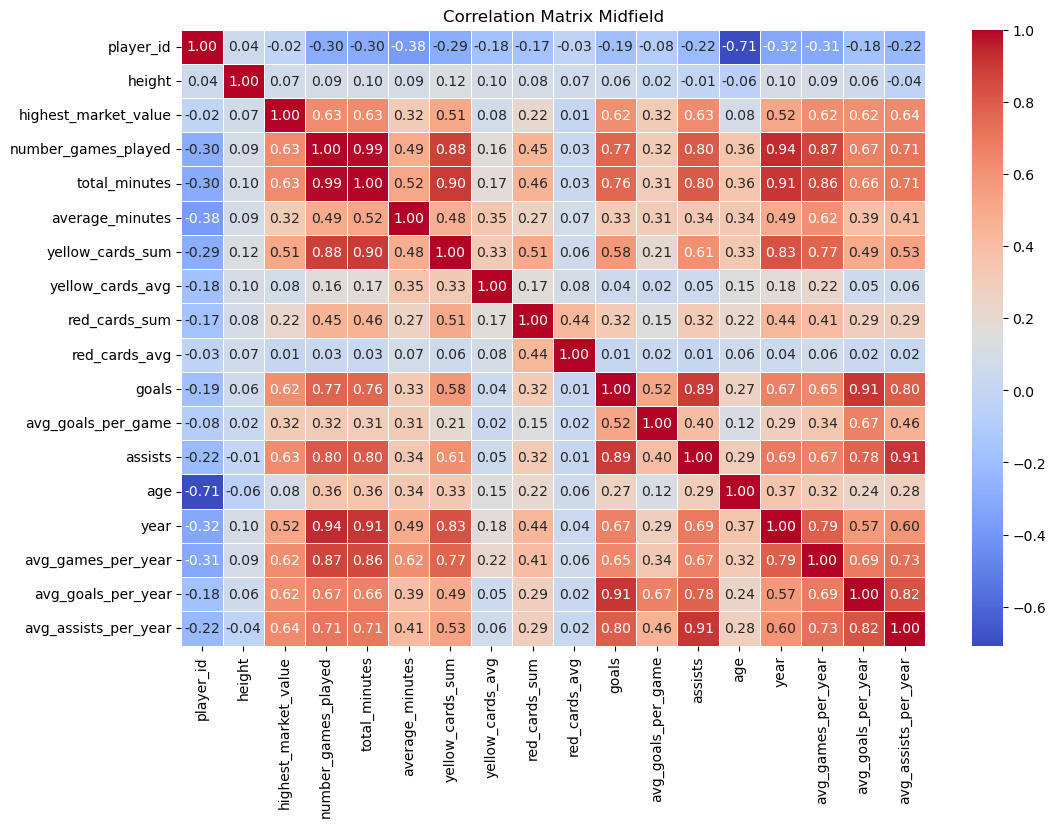

In [28]:
# Plot correlation matrix for Midfield
plot_correlation_matrix(df, 'Correlation Matrix Midfield', 'Midfield')

We see similar correlations to the defender analysis, so since defenders and midfielders can have similar roles on the pitch, we will continue with the same features.

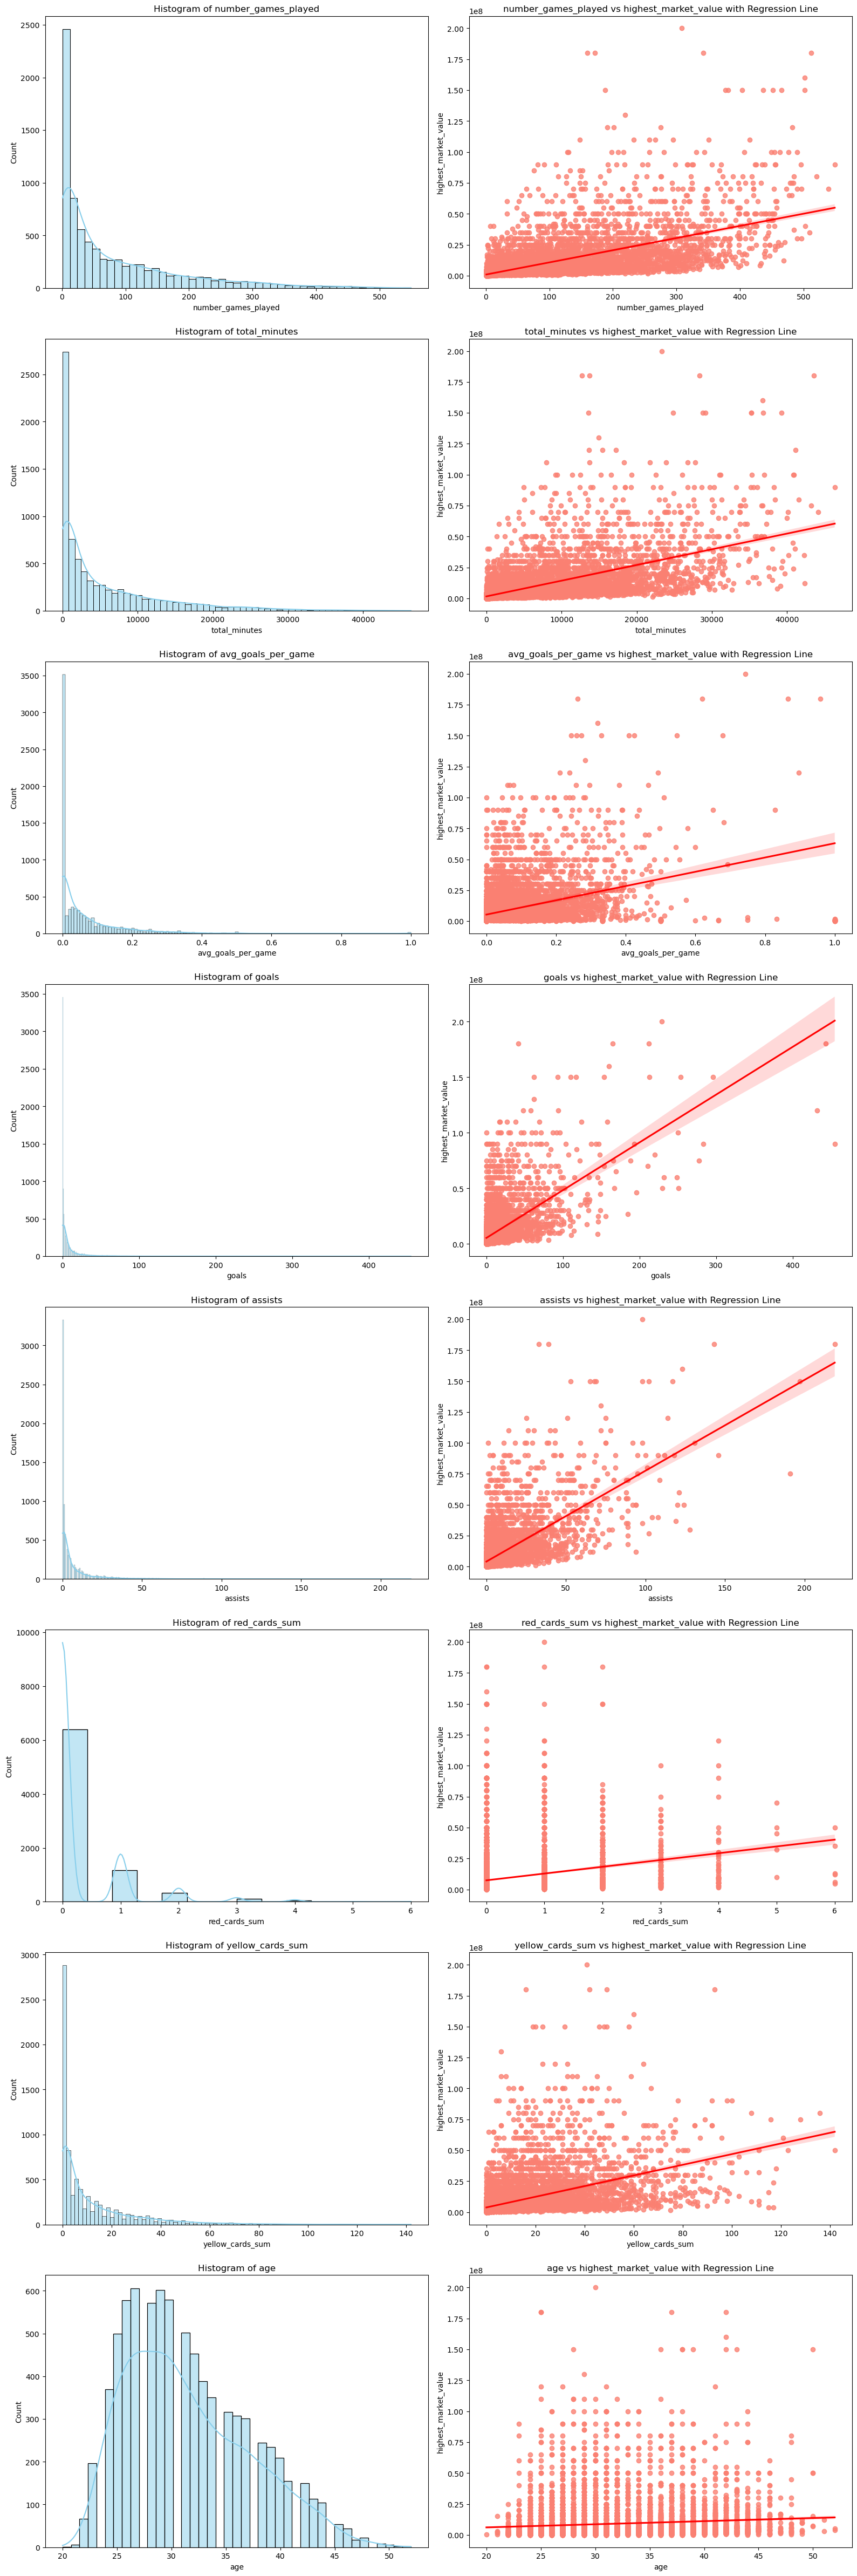

In [11]:
# List of performance features for Midfield
features_midfield = [
    'number_games_played',
    'total_minutes',
    'avg_goals_per_game',
    'goals',
    'assists',
    'red_cards_sum',
    'yellow_cards_sum',
    'age'
]

# Plot insightful plots for Midfield
plot_variable_distributions_with_regression(df, features_midfield)

## Midfield Performance Analysis

#### Plot Analysis:

- **Right Skewed Distributions**: Histograms show right-skewed distributions for key metrics such as **assists**, **red cards**, **yellow cards**, **games played**, **total minutes played**, **average goals per game** and **age**.
- Positive trends: Scatter plots with regression lines indicate positive trends between critical metrics such as **assists**, **games played**, **average goals per game** and **market value**.

#### Correlation conclusions:

- **Similar correlations**: The analysis of midfielders' performance mirrors that of defenders, showing comparable correlations between various performance metrics and disciplinary records and footballers' highest market value.
- **Weaker Correlations**: Some metrics such as **yellow cards** and **red cards** show weaker correlations compared to others.
- **Strong correlations**: In particular, there's a **strong correlation** between **support** and **market value**.
- **Moderate Correlations**: Metrics such as **games played** and **average goals per game** show **moderate correlations** with market value.


In [30]:
midfield_results = train_and_evaluate_models(df, 'Midfield', features_midfield)

print(f"Model evaluation results for Midfield position:")

for model_name, metrics in midfield_results.items():
    print(f"\n{model_name}:")
    if 'R^2 score' in metrics:
        print(f"  R^2 score: {metrics['R^2 score']:.4f}")
    if 'Cross-Validation R^2 mean' in metrics:
        print(f"  Cross-Validation R^2 score: {metrics['Cross-Validation R^2 mean']:.4f}")
    if 'Cross-Validation R^2 std' in metrics:
        print(f"  Standard Deviation of CV R^2: {metrics['Cross-Validation R^2 std']:.4f}")
    intercept = metrics.get('Intercept')
    p_value = metrics.get('P-value')
    f_value = metrics.get('F-value')
    if all((intercept is not None, p_value is not None, f_value is not None)):
        print(f"  Intercept: {intercept:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  F-value: {f_value:.4f}")

Model evaluation results for Midfield position:

LinearRegression:
  R^2 score: 0.4818
  Cross-Validation R^2 score: 0.4475
  Standard Deviation of CV R^2: 0.0354
  Intercept: 9460910.2640
  P-value: 0.0000
  F-value: 214.7137

RidgeRegression:
  R^2 score: 0.4820
  Cross-Validation R^2 score: 0.4477
  Standard Deviation of CV R^2: 0.0353
  Intercept: 9460910.2640
  P-value: 0.0000
  F-value: 214.7137

LassoRegression:
  R^2 score: 0.4818
  Cross-Validation R^2 score: 0.4475
  Standard Deviation of CV R^2: 0.0354
  Intercept: 9460910.2640
  P-value: 0.0000
  F-value: 214.7137

PolynomialRegression:
  R^2 score: 0.4440
  Cross-Validation R^2 score: 0.4539
  Standard Deviation of CV R^2: 0.0751

RandomForestRegressor:
  R^2 score: 0.4927
  Cross-Validation R^2 score: 0.4365
  Standard Deviation of CV R^2: 0.0543

GradientBoostingRegressor:
  R^2 score: 0.5064
  Cross-Validation R^2 score: 0.4337
  Standard Deviation of CV R^2: 0.0635

SVR:
  R^2 score: -0.1481
  Cross-Validation R^2 scor

### Midfield model evaluation

As expected, during the whole analysis we have compared it with the one done before for the defenders, etc., the values of the models for the midfield have a lot of similarities with the values of the models for the defenders, but still different, and in this case they are mostly a little bit bigger. Based on the results:

- **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** perform well, but we have to note that **RidgeRegression** has the highest R^2 and Cross-Validation R^2 values and is the most indicated for predicting the market value. It is closely followed by **LinearRegression** and **LassoRegression**. **PolynomialRegression is also promising, but it's the worst of these four models.
  
- **RandomForestRegressor** and **GradientBoostingRegressor** have lower scores than the other four models, but still perform better than **SVR**, which has negative scores indicating poor performance.

Therefore, **RidgeRegression**, **LinearRegression**, **LassoRegression** and **PolynomialRegression** are expected to give better predictions for the defender's position.


## Market value prediction for new players

### Example of predicting a new player with a defender position

In this section, we use the previously trained models to estimate market value. We'll give an overview of the estimated market values generated by each model.

However, at the end of our analysis, we'll make a final selection based on performance, specifically tailored to each player's position, in order to select the most accurate market value.

Predicted market value for new player using LinearRegression: 26577541299.580097
Predicted market value for new player using RidgeRegression: 25145904770.441647
Predicted market value for new player using LassoRegression: 26576805251.986492
Predicted market value for new player using PolynomialRegression: -28567825342097.945
Predicted market value for new player using RandomForestRegressor: 11162000.0
Predicted market value for new player using GradientBoostingRegressor: 7552178.114986472
Predicted market value for new player using SVR: 3499367.2255885135


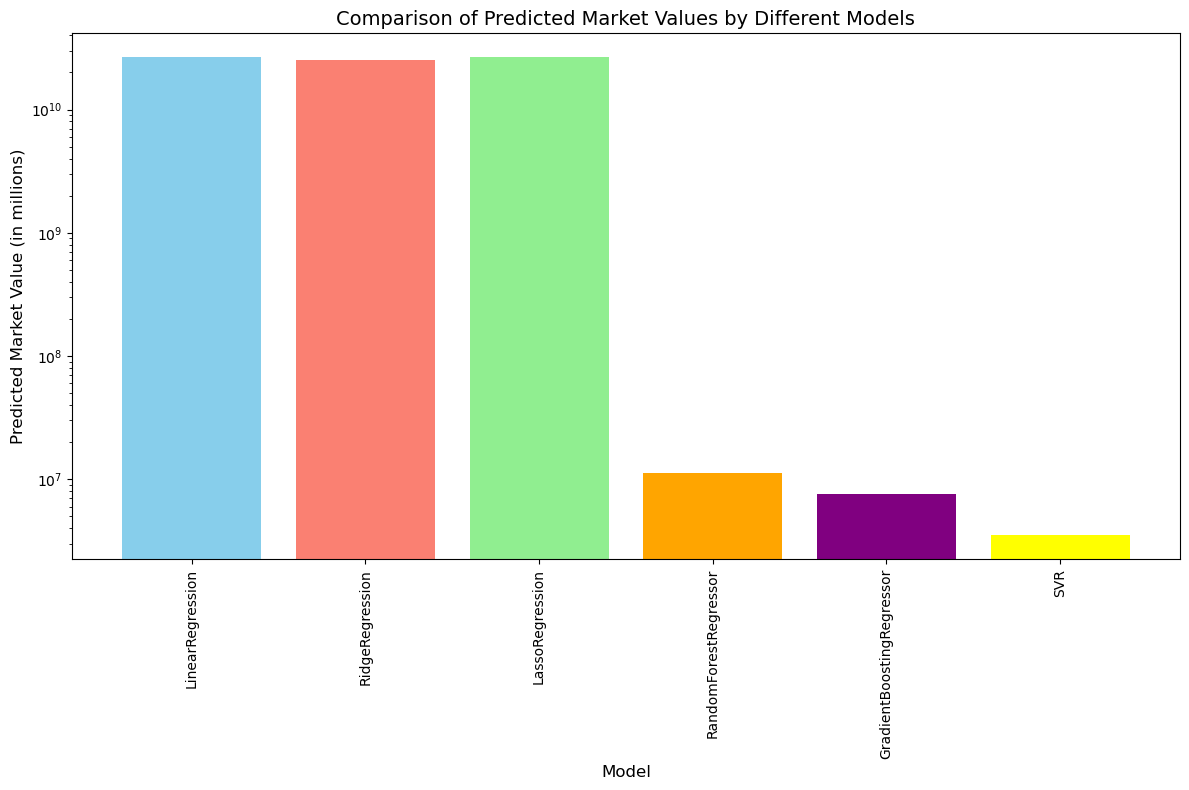

In [49]:
# Define the features of our players
new_player_data = {
    'number_games_played': 120,
    'total_minutes': 3500,
    # Add more features 
}

# Call the predict_market_value_for_new_player function with correct arguments
predictions = predict_market_value_for_new_player(defender_results['trained_models'], features_defender, new_player_data)

# Print predicted values for each model
for model_name, predicted_value in predictions.items():
    print(f"Predicted market value for new player using {model_name}: {predicted_value}")

# Filter out negative predictions for plotting
filtered_predictions = {model: value for model, value in predictions.items() if value >= 0}

# Plot the predictions with logarithmic scale
plt.figure(figsize=(12, 8))

model_names = list(filtered_predictions.keys())
predicted_values = list(filtered_predictions.values())
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'yellow', 'cyan']

plt.bar(model_names, predicted_values, color=colors)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Predicted Market Value (in millions)', fontsize=12)
plt.title('Comparison of Predicted Market Values by Different Models', fontsize=14)
plt.xticks(rotation=90)
plt.yscale('log') 
plt.tight_layout()
plt.show()


Based on the predictions and model valuation results:

- **LinearRegression**, **RidgeRegression** and **LassoRegression** all predict very high market values for the new player features introduced. We affirm that these predictions are consistent with their relatively high R^2 scores and cross-validation R^2 scores, which fully explain the variance in the data. However, it's important to note that these models may be overfitting of the data due to predicted values being too high.

- The **PolynomialRegression** predicts a negative market value, so we decide not to include it as the results are irrelevant.

- The **RandomForestRegressor** and **GradientBoostingRegressor** predict much lower market values than the linear models, in the millions. This is consistent with their lower R^2 scores and cross-validation R^2 scores, indicating less predictive power than the linear models.

- SVR** predicts the lowest market value of all the models, which is consistent with its negative R^2 score and Cross-Validation R^2 score, indicating poor performance in explaining the variance in the data.

In summary, based on the predictions and model evaluation results, the linear models (**LinearRegression**, **RidgeRegression** and **LassoRegression**) appear to predict higher market values for the new player compared to other models. However, given the excessively high predicted values, it may be necessary to further investigate the performance of the models and maybe look for a better fit.